# RNA Dataset Titanic
## Curso Machine Learning Avanzado

### Importación de librerías y dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import models, layers, optimizers, regularizers
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#Cargamos el dataset de entrenamiento
dataset = pd.read_csv("/Users/joseignaciozamora/Desktop/Macbook/Magister/Magister/Machine Learning Avanzado/MLA DB/titanic/train.csv")
dataset = pd.DataFrame(dataset)

In [3]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Preprocesamiento de datos

In [4]:
#Eliminamos la columna Cabin dado que tiene pocos datos y nos hace imposible poder normalizar nuestro dataset.
#Al igual que PassengerId, Name y Ticket que no son representativas para el analisis, por ende, las eliminamos.

dataset_2 = dataset.drop(["Cabin","PassengerId", "Name", "Ticket"],axis=1)

In [5]:
#Aun nos queda rellenar los embarked que son 2 datos y rellenaremos con la moda.

moda = dataset_2.Embarked.mode()

dataset_2.loc[dataset_2.Embarked.isnull(), "Embarked"] = "S"
print(f"La moda de Emarked es: {moda}")
dataset_2.info()

La moda de Emarked es: 0    S
Name: Embarked, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [6]:
#Convertimos las columnas Sex y Embarked en valores.
def valores(x):
    x['Sex'].replace('female', 0,inplace=True)
    x['Sex'].replace('male', 1,inplace=True)
    x['Embarked'].replace('S', 0,inplace=True)
    x['Embarked'].replace('C', 1,inplace=True)
    x['Embarked'].replace('Q', 2,inplace=True)
valores(dataset_2)
len(dataset_2)

891

<AxesSubplot:>

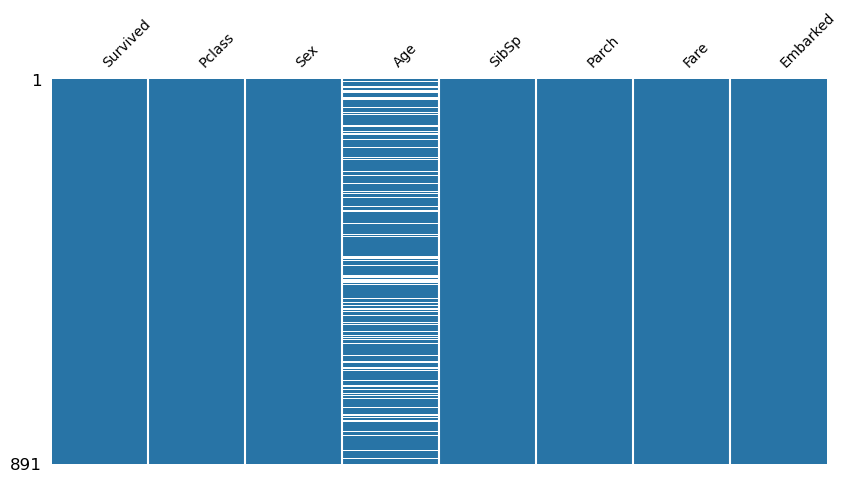

In [7]:
#Vemos graficamente la perdida de información de las columnas, esto nos indica una fuerte perdida de información,
#en la columna Age y unas cuantas en Embarked.

import missingno as msno
%matplotlib inline

rgb_Color = (40/255, 116/255, 166/255)
msno.matrix(dataset_2, color= rgb_Color, sparkline = False , figsize=(10,5), fontsize=10)

In [8]:
#Dado que son tan pocos datos, no eliminaremos las filas sin información, por ende,
#procederemos a rellenar la información con la media de valores en base a Supervivencia, Sexo y Cabina.

for s in range(0, 2):
    for c in range(1, 4):
        for g in range(0,2):
            mean = (dataset_2.Age[(dataset_2.Survived == s) & (dataset_2.Pclass == c) & (dataset_2.Sex == g)].mean())
            dataset_2.loc[(dataset_2.Age.isnull()) & (dataset_2.Survived == s) & (dataset_2.Pclass == c) & (dataset_2.Sex == g), "Age"] = mean   
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [9]:
#Reescalamos las edades y tarifas con RobustScaler para elimimar el efecto de los outliers
from sklearn.preprocessing import RobustScaler
# Revisamos los outliers
Q1 = dataset_2[["Age","Fare"]].quantile(0.25)
Q3 = dataset_2[["Age","Fare"]].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
RS = RobustScaler(with_centering=False, with_scaling=True)
dataset_2[["Age","Fare"]] = RS.fit_transform(dataset_2[["Age","Fare"]])


Age     15.0000
Fare    23.0896
dtype: float64


In [10]:
dataset_2[["Age","Fare"]]

,Age,Fare
0,1.466667,0.313994
1,2.533333,3.087247
2,1.733333,0.343228
3,2.333333,2.299737
4,2.333333,0.348642
...,...,...
886,1.800000,0.563024
887,1.266667,1.299286
888,1.587879,1.015609
889,1.733333,1.299286


In [11]:
titanic_X = dataset_2.drop("Survived", axis =1)
titanic_X


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,1.466667,1,0,0.313994,0
1,1,0,2.533333,1,0,3.087247,1
2,3,0,1.733333,0,0,0.343228,0
3,1,0,2.333333,1,0,2.299737,0
4,3,1,2.333333,0,0,0.348642,0
...,...,...,...,...,...,...,...
886,2,1,1.800000,0,0,0.563024,0
887,1,0,1.266667,0,0,1.299286,0
888,3,0,1.587879,1,2,1.015609,0
889,1,1,1.733333,0,0,1.299286,1


In [12]:
#Y armamos nuestro dataset y_train
titanic_y = dataset_2["Survived"]

In [13]:
#Los convertemos en arreglos de numpy
titanic_X = np.array(titanic_X)
titanic_y = np.array(titanic_y)

#Y los normalizamos
from sklearn.preprocessing import normalize

titanic_X_norm = normalize(titanic_X)
print(len(titanic_X_norm))
print(len(titanic_y))

891
891


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(titanic_X_norm, titanic_y, test_size= 0.9, random_state=1)

In [18]:
#Parametros de la RNA

hidden_units = 10     # how many neurons in the hidden layer
activation = 'relu'   # activation function for hidden layer
l2 = 0.001             # regularization - how much we penalize large parameter values
                     
learning_rate = 0.001  # how big our steps are in gradient descent
epochs = 300            # how many epochs to train for
batch_size = 30       # how many samples to use for each gradient descent update


In [19]:
#Corroboramos la cantidad de datos en nuestros sets de entrenamiento
print(len(titanic_X_norm))
print(len(titanic_y))


#Creamos un arreglo con la cantidad de columnas del set de entrenamiento X.
titanic_x_names = pd.DataFrame(titanic_X_norm).columns.values
titanic_x_names

891
891


array([0, 1, 2, 3, 4, 5, 6])

Epoch 1/300
 6/30 [=====>........................] - ETA: 0s - loss: 3.7029 - accuracy: 0.5889

2022-11-15 20:23:39.011590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 2.4082 - accuracy: 0.6162

2022-11-15 20:23:39.506024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 20ms/step - loss: 2.4082 - accuracy: 0.6162 - val_loss: 1.3319 - val_accuracy: 0.6110
Epoch 2/300
30/30 [==============================] - 0s 13ms/step - loss: 1.1173 - accuracy: 0.6162 - val_loss: 1.0123 - val_accuracy: 0.6110
Epoch 3/300
30/30 [==============================] - 0s 13ms/step - loss: 0.9323 - accuracy: 0.6162 - val_loss: 0.8689 - val_accuracy: 0.6110
Epoch 4/300
30/30 [==============================] - 0s 13ms/step - loss: 0.7884 - accuracy: 0.6162 - val_loss: 0.7386 - val_accuracy: 0.6110
Epoch 5/300
30/30 [==============================] - 0s 12ms/step - loss: 0.6988 - accuracy: 0.6162 - val_loss: 0.6750 - val_accuracy: 0.6110
Epoch 6/300
30/30 [==============================] - 0s 12ms/step - loss: 0.6600 - accuracy: 0.6162 - val_loss: 0.6521 - val_accuracy: 0.6135
Epoch 7/300
30/30 [==============================] - 0s 13ms/step - loss: 0.6444 - accuracy: 0.6263 - val_loss: 0.6402 - val_accuracy: 0.6446
Epoch 8/300
30/30 

30/30 [==============================] - 0s 12ms/step - loss: 0.4292 - accuracy: 0.7980 - val_loss: 0.4322 - val_accuracy: 0.8005
Epoch 59/300
30/30 [==============================] - 0s 11ms/step - loss: 0.4284 - accuracy: 0.7957 - val_loss: 0.4307 - val_accuracy: 0.7993
Epoch 60/300
30/30 [==============================] - 0s 12ms/step - loss: 0.4277 - accuracy: 0.7980 - val_loss: 0.4299 - val_accuracy: 0.8005
Epoch 61/300
30/30 [==============================] - 0s 11ms/step - loss: 0.4260 - accuracy: 0.7991 - val_loss: 0.4282 - val_accuracy: 0.7993
Epoch 62/300
30/30 [==============================] - 0s 11ms/step - loss: 0.4251 - accuracy: 0.7980 - val_loss: 0.4275 - val_accuracy: 0.8005
Epoch 63/300
30/30 [==============================] - 0s 12ms/step - loss: 0.4252 - accuracy: 0.8002 - val_loss: 0.4278 - val_accuracy: 0.8055
Epoch 64/300
30/30 [==============================] - 0s 12ms/step - loss: 0.4253 - accuracy: 0.8036 - val_loss: 0.4274 - val_accuracy: 0.8042
Epoch 65/300

30/30 [==============================] - 0s 12ms/step - loss: 0.3911 - accuracy: 0.8215 - val_loss: 0.3899 - val_accuracy: 0.8279
Epoch 116/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3912 - accuracy: 0.8238 - val_loss: 0.3889 - val_accuracy: 0.8292
Epoch 117/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3895 - accuracy: 0.8193 - val_loss: 0.3892 - val_accuracy: 0.8292
Epoch 118/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3893 - accuracy: 0.8227 - val_loss: 0.3889 - val_accuracy: 0.8279
Epoch 119/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3902 - accuracy: 0.8227 - val_loss: 0.3895 - val_accuracy: 0.8292
Epoch 120/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3910 - accuracy: 0.8204 - val_loss: 0.3924 - val_accuracy: 0.8254
Epoch 121/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3925 - accuracy: 0.8283 - val_loss: 0.3889 - val_accuracy: 0.8279
Epoch 

Epoch 172/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3718 - accuracy: 0.8272 - val_loss: 0.3680 - val_accuracy: 0.8367
Epoch 173/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3698 - accuracy: 0.8272 - val_loss: 0.3684 - val_accuracy: 0.8342
Epoch 174/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3689 - accuracy: 0.8283 - val_loss: 0.3668 - val_accuracy: 0.8379
Epoch 175/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3686 - accuracy: 0.8272 - val_loss: 0.3657 - val_accuracy: 0.8367
Epoch 176/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3711 - accuracy: 0.8283 - val_loss: 0.3670 - val_accuracy: 0.8329
Epoch 177/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3698 - accuracy: 0.8283 - val_loss: 0.3666 - val_accuracy: 0.8342
Epoch 178/300
30/30 [==============================] - 0s 13ms/step - loss: 0.3703 - accuracy: 0.8272 - val_loss: 0.3731 - val_accuracy:

Epoch 229/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3578 - accuracy: 0.8350 - val_loss: 0.3569 - val_accuracy: 0.8354
Epoch 230/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3576 - accuracy: 0.8328 - val_loss: 0.3593 - val_accuracy: 0.8354
Epoch 231/300
30/30 [==============================] - 0s 12ms/step - loss: 0.4105 - accuracy: 0.8272 - val_loss: 0.6270 - val_accuracy: 0.7943
Epoch 232/300
30/30 [==============================] - 0s 11ms/step - loss: 0.4596 - accuracy: 0.8159 - val_loss: 0.4159 - val_accuracy: 0.8055
Epoch 233/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3906 - accuracy: 0.8193 - val_loss: 0.3837 - val_accuracy: 0.8317
Epoch 234/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3748 - accuracy: 0.8238 - val_loss: 0.3703 - val_accuracy: 0.8329
Epoch 235/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3654 - accuracy: 0.8283 - val_loss: 0.3626 - val_accuracy:

Epoch 286/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3519 - accuracy: 0.8350 - val_loss: 0.3515 - val_accuracy: 0.8392
Epoch 287/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3549 - accuracy: 0.8350 - val_loss: 0.3618 - val_accuracy: 0.8392
Epoch 288/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3653 - accuracy: 0.8227 - val_loss: 0.3881 - val_accuracy: 0.8342
Epoch 289/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3789 - accuracy: 0.8328 - val_loss: 0.3694 - val_accuracy: 0.8379
Epoch 290/300
30/30 [==============================] - 0s 11ms/step - loss: 0.3604 - accuracy: 0.8305 - val_loss: 0.3509 - val_accuracy: 0.8329
Epoch 291/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3517 - accuracy: 0.8328 - val_loss: 0.3519 - val_accuracy: 0.8354
Epoch 292/300
30/30 [==============================] - 0s 12ms/step - loss: 0.3537 - accuracy: 0.8305 - val_loss: 0.3520 - val_accuracy:

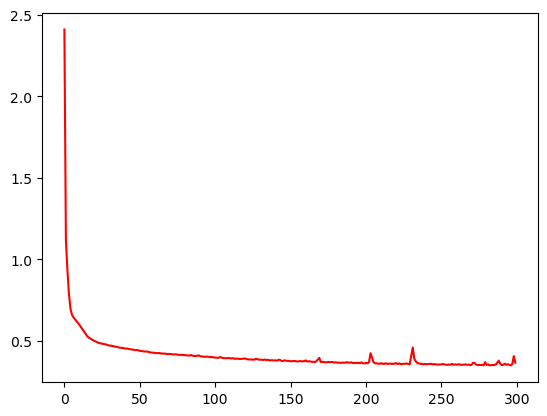

In [20]:
# create a seModeloquential model
## Viene de KERAS!
model = models.Sequential()

# Primera capa oculta de 20 nodos
model.add(layers.Dense(input_dim=len(titanic_x_names),
                       units=hidden_units, 
                       activation=activation))

# Segunda capa oculta de 20 nodos
model.add(layers.Dense(input_dim=hidden_units,
                       units=hidden_units, 
                       activation='relu'))

# Tercera capa oculta de 20 nodos
model.add(layers.Dense(input_dim=hidden_units,
                       units=hidden_units, 
                       activation='relu'))

# final de la red, outputs
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='relu'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

# train the parameters
history = model.fit(titanic_X_norm, titanic_y, epochs=epochs, batch_size=batch_size, validation_data= (X_val, y_val))

# evaluate accuracy
train_acc = model.evaluate(titanic_X_norm, titanic_y, batch_size=32)[1]
#test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
#print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()
